In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt


class EnvBase:
    def __init__(self):
        pass
    def reset(self):
        pass
    def step(self):
        pass
    def get_state(self):
        pass


def burgers(y, u, delta_t, delta_x, nu=0.01):
    """
    Return the change rate of state vector, given the current state y and control signal u, following 1D Burgers' equation.

    :param y: (n,), state vector.
    :param u: (m,), control signal.
    :param delta_t: a small physical time, used as dt in the numerical solution of differential equation.
    :param delta_x: a small spatial length, used as dx in the numerical solution of differential equation.
    :param nu: Kinematic viscosity.

    :return: (n,), change rate of state vector
    """
    assert type(y) == np.ndarray and type(u) == np.ndarray, "y and u must be numpy arrays"
    assert y.ndim == 1 and u.ndim == 1, "y and u must be 1 dimensional arrays"
    assert y.shape == u.shape, "y and u must have the same shape"
    
    y_b = np.roll(y, -1)
    y_b[-1] = y[-1]
    y_a = np.roll(y, 1)
    y_a[0] = y[0]
    dydt = -y * (y_b - y_a) / (2 * delta_x) + nu * (y_b - 2 * y + y_a) / delta_x**2
    return dydt + u  # Adding control influence to the state evolution


class Burgers(EnvBase):
    def __init__(self,
                    n=128,
                    m=128,
                    T=16,
                    x_range=[-1, 1],
                    energy_penalty=0.01,
                    device='cpu',
                    seed=12345
                    ):
        '''
        n: number of nodes
        m: number of driver nodes
        T: Number of time steps
        T_sim: Total simulation time (a physical time)
        energy_penalty: penalty coefficent for energy. Energy is calculated as the sum of the square of the action vector.
        '''
        super().__init__()
        assert n==m, "Invalid input"
        self.num_nodes = n
        self.num_driver = m
        self.state_dim = n
        self.action_dim = m
        self.T = T
        self.energy_penalty = energy_penalty
        self.x_range = x_range

        self.device = device
        self.seed = seed

        self.dt = 0.01 # physical time length
        self.dx = (x_range[1]-x_range[0])/n # spatial length, used as dx in the numerical solution of differential equation. (Assume equal spacing)
        self.current_state=np.zeros(n)
        self.t=0 # Current time index. An integer between 0 and T-1.

        np.random.seed(self.seed)


    def add_target_state(self, target_state): # TODO
        '''
        Add a target state to the environment.
        '''
        self.target_state = target_state

    def calculate_state_reward(self, state):
        '''
        Calculate the reward for a given state. This is not the total reward, just the state part.
        '''
        return -np.sum(np.square(state - self.target_state))

    def calculate_action_reward(self, action):
        '''
        Calculate the reward for a given action. This is not the total reward, just the action part.
        '''
        return -np.sum(np.square(action))

    def reset(self, start=None):
        '''
        Reset the environment to a initial state.
        '''
        if start is not None: # If the initial state is given, use it.
            self.current_state = start
            self.t = 0
            return self.current_state
        else: # If the initial state is not given, randomly initialize the state.
            self.current_state = np.random.randn(self.num_nodes)
            self.t = 0
            return self.current_state

    def step(self, action):
        '''
        action: (m,), the control signal input
        '''
        next_state = self.current_state + burgers(self.current_state, action, self.dt, self.dx)*self.dt
        next_state[0]=0
        next_state[-1]=0
        reward = self.calculate_state_reward(next_state)+self.calculate_action_reward(action)*self.energy_penalty
        done = False if self.t < self.T-1 else True
        self.current_state = next_state # update current state
        self.t += 1 # update time index
        return next_state, reward, done

    def get_state(self):
        return self.current_state


    def get_dataset(self, num_samples=10000, noise_std=0.01):
        '''
        Generate a dataset of state-action pairs.
        '''
        self.reset()
        dataset = {}
        for i in range(num_samples):
            action = np.random.randn(self.num_driver) * noise_std
            state, reward, done = self.step(action)
            dataset.append((state, action))
    



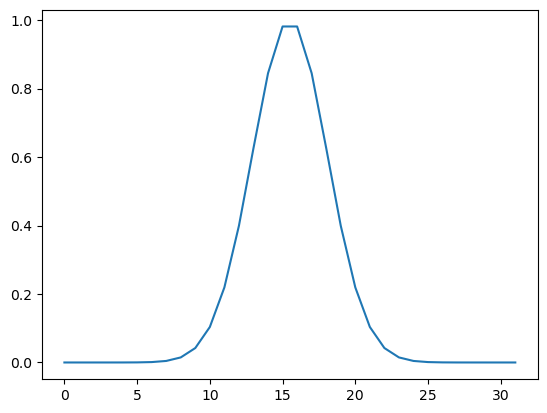

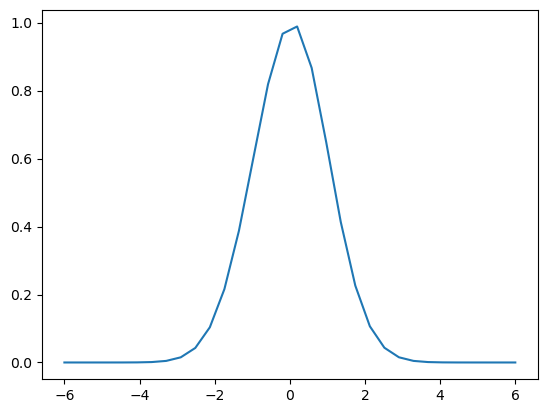

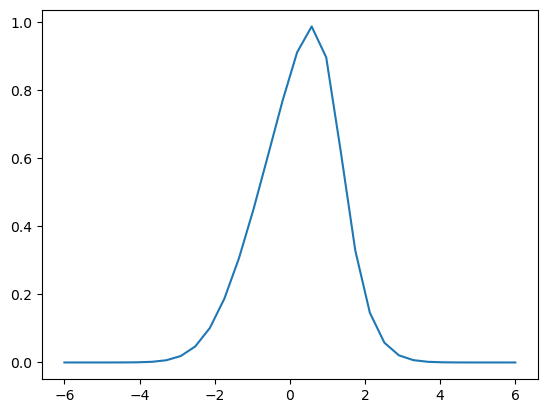

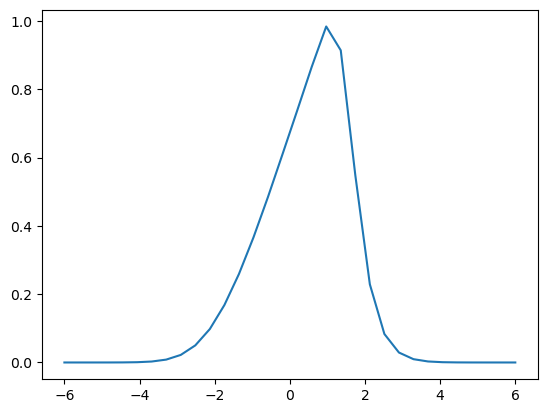

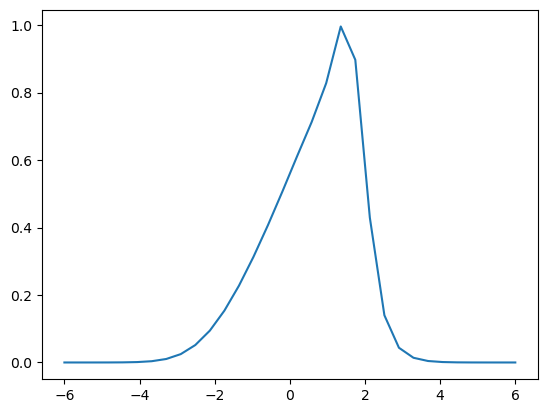

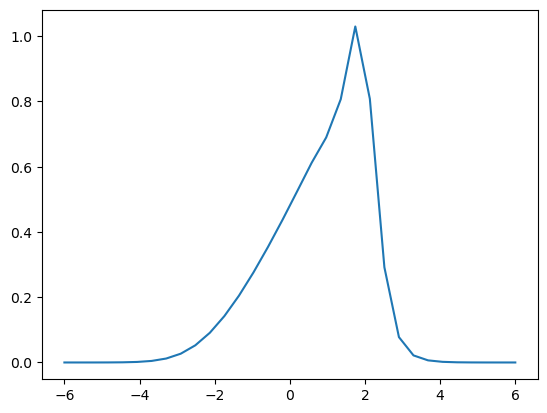

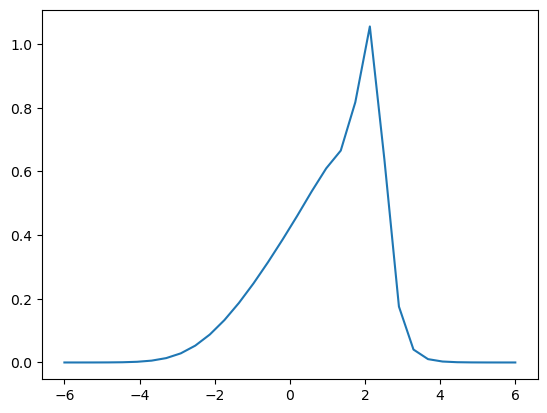

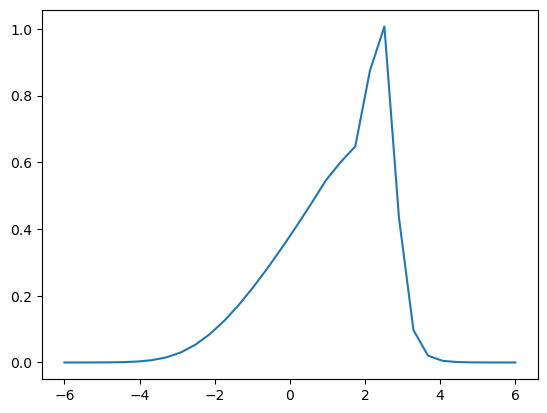

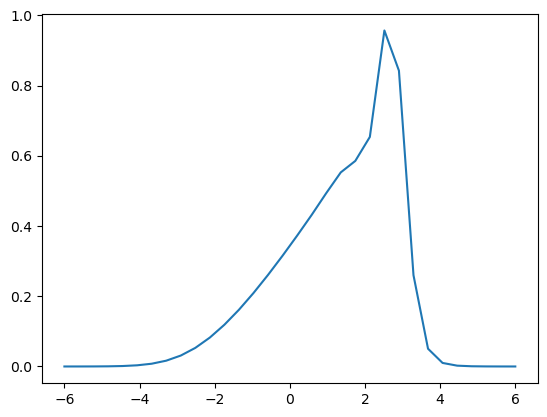

In [46]:
n=32
m=32

env=Burgers(n=n, m=m, T=16, x_range=[-1, 1], energy_penalty=0.01, device='cpu', seed=12331)



x=np.linspace(-6,6,n)
start=np.exp(-0.5*x**2)

env.reset(start)
env.add_target_state(np.zeros(n))
plt.plot(env.current_state)
plt.show()
for i in range(80):
    #action=0.1*np.random.randn(32)
    action=np.zeros(m)
    env.step(action)
    #print(env.get_state())
    if i%10==0:
        plt.plot(x,env.current_state)
        #print(burgers(env.current_state,0*np.random.randn(m),0.1,0.1,0.1))
        plt.show()

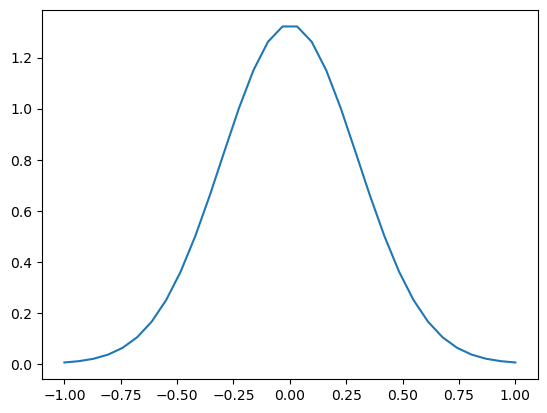

In [9]:
from scipy.stats import norm
x = np.linspace(-1, 1, 32)

# 计算正态分布的概率密度函数值
pdf_values = norm.pdf(x, scale=0.3)
plt.plot(x, pdf_values)
plt.show()


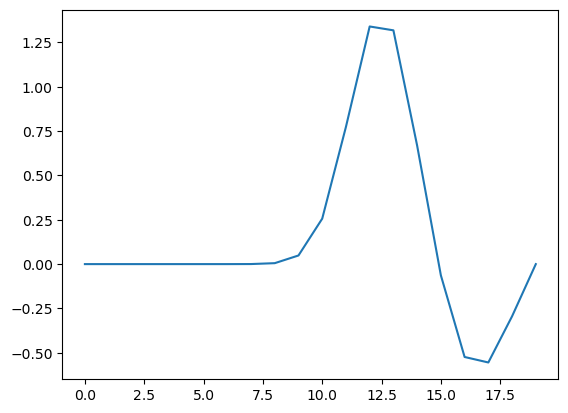

In [2]:
def generate_initial_u(x):
    """
    Generate the initial state u(0, x) as a superposition of two Gaussian functions.
    """
    # Sampling parameters for the Gaussian functions
    a1 = np.random.uniform(0, 2)
    a2 = np.random.uniform(-2, 0)
    b1 = np.random.uniform(0.2, 0.4)
    b2 = np.random.uniform(0.6, 0.8)
    sigma1 = np.random.uniform(0.05, 0.15)
    sigma2 = np.random.uniform(0.05, 0.15)
    
    u = a1 * np.exp(-((x - b1)**2) / (2 * sigma1**2)) + a2 * np.exp(-((x - b2)**2) / (2 * sigma2**2))
    u[0] = 0
    u[-1] = 0
    return u
plt.plot(generate_initial_u(np.linspace(-1, 1, 20)))

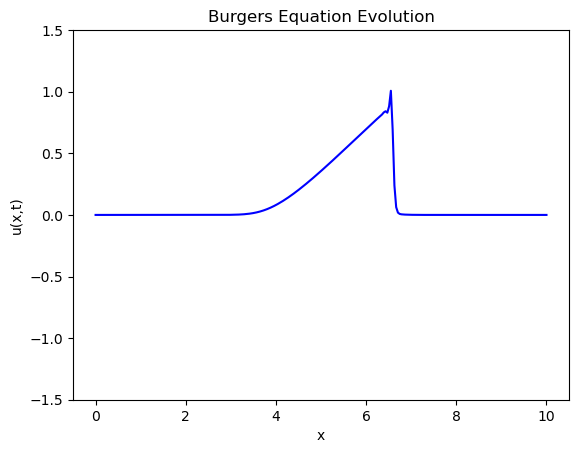

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 设置参数
L = 10.0               # 空间区间长度
T = 2.0                # 总时间
Nx = 256               # 空间格点数
Nt = 200               # 时间步数
nu = 0.01              # 粘度系数

# 网格划分
dx = L / (Nx - 1)      # 空间步长
dt = T / Nt            # 时间步长
x = np.linspace(0, L, Nx)  # 空间坐标

# 初始条件：正态分布
u0 = np.exp(-0.5 * ((x - L/2) / 0.5)**2)

# 初始化u，设置为初始条件
u = np.copy(u0)

# 设置绘图
fig, ax = plt.subplots()
line, = ax.plot(x, u, color='b')
ax.set_ylim(-1.5, 1.5)
ax.set_title('Burgers Equation Evolution')
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

# 计算Burgers方程的数值解
def update(frame):
    global u
    u_new = np.copy(u)
    for i in range(1, Nx - 1):
        # 使用有限差分法更新
        u_new[i] = u[i] - dt * u[i] * (u[i+1] - u[i-1]) / (2 * dx) + nu * dt / (dx**2) * (u[i+1] - 2*u[i] + u[i-1])
    
    u = np.copy(u_new)  # 更新u
    line.set_ydata(u)    # 更新图形
    return line,

# 创建动画
ani = FuncAnimation(fig, update, frames=Nt, interval=50, blit=True)
from IPython.display import HTML
HTML(ani.to_jshtml())

# 显示动画
plt.show()


In [62]:
def burgers(y, u, delta_t, delta_x, nu=0.1):
    """
    Return the change rate of state vector, given the current state y and control signal u, following 1D Burgers' equation.

    :param y: (n,), state vector.
    :param u: (m,), control signal.
    :param delta_t: a small physical time, used as dt in the numerical solution of differential equation.
    :param delta_x: a small spatial length, used as dx in the numerical solution of differential equation.
    :param nu: Kinematic viscosity.

    :return: (n,), change rate of state vector
    """
    assert type(y) == np.ndarray and type(u) == np.ndarray, "y and u must be numpy arrays"
    assert y.ndim == 1 and u.ndim == 1, "y and u must be 1 dimensional arrays"
    assert y.shape == u.shape, "y and u must have the same shape"
    
    y_b = np.roll(y, -1)
    y_b[-1] = y[-1]
    y_a = np.roll(y, 1)
    y_a[0] = y[0]
    dydt = -y * (y_b - y_a) / (2 * delta_x) + nu * (y_b - 2 * y + y_a) / delta_x**2
    return dydt + u  # Adding control influence to the state evolution



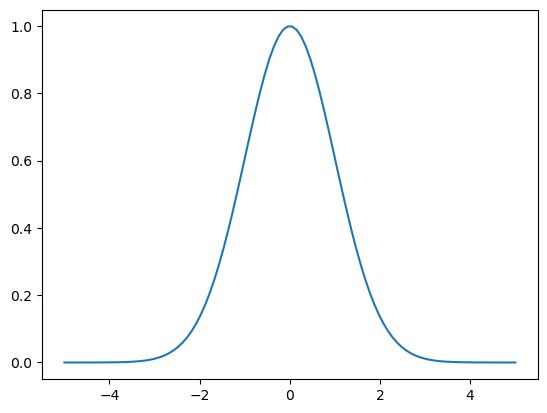

0


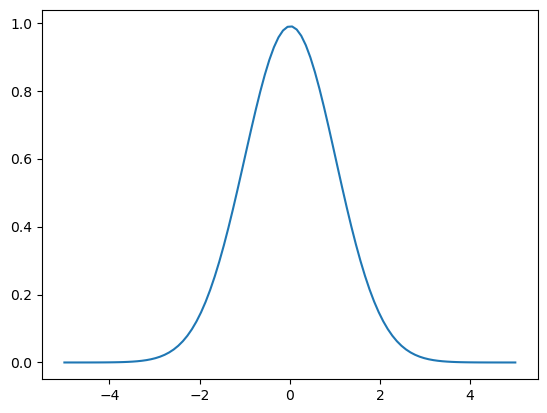

10


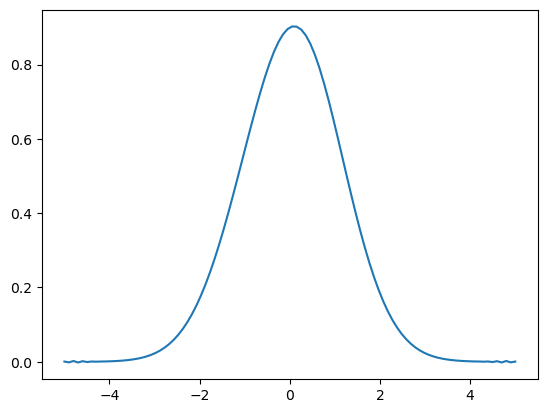

20


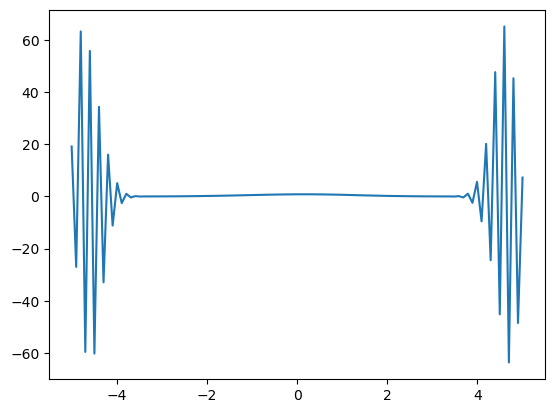

30


C:\Users\24021\AppData\Local\Temp\ipykernel_3048\3149605552.py:21: RuntimeWarning: overflow encountered in multiply
  dydt = -y * (y_b - y_a) / (2 * delta_x) + nu * (y_b - 2 * y + y_a) / delta_x**2


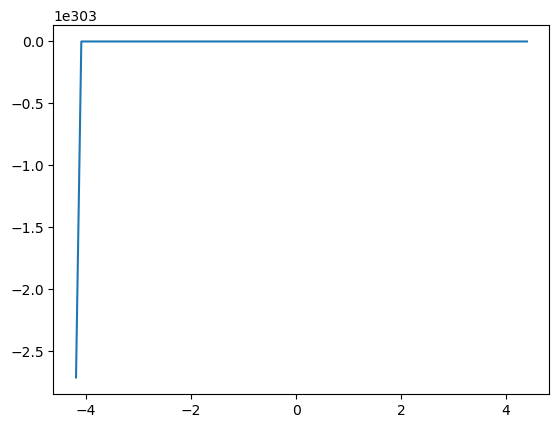

40


C:\Users\24021\AppData\Local\Temp\ipykernel_3048\3149605552.py:21: RuntimeWarning: invalid value encountered in subtract
  dydt = -y * (y_b - y_a) / (2 * delta_x) + nu * (y_b - 2 * y + y_a) / delta_x**2
C:\Users\24021\AppData\Local\Temp\ipykernel_3048\3149605552.py:21: RuntimeWarning: invalid value encountered in add
  dydt = -y * (y_b - y_a) / (2 * delta_x) + nu * (y_b - 2 * y + y_a) / delta_x**2
C:\Users\24021\AppData\Local\Temp\ipykernel_3048\105799204.py:9: RuntimeWarning: invalid value encountered in add
  y+=burgers(y,0.0*np.exp(-0.5*x**2),dt,10/n,nu)*dt


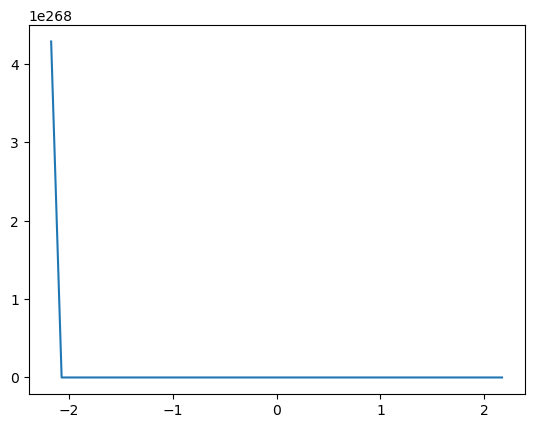

50


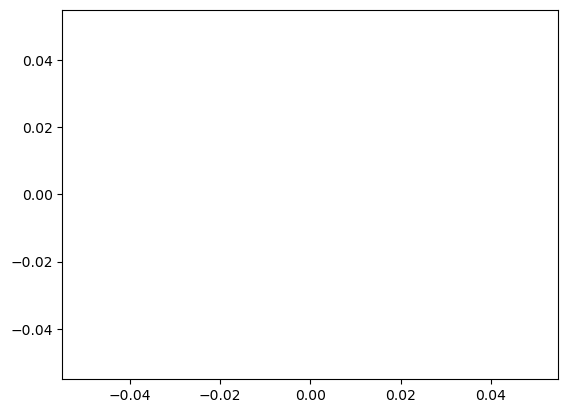

60


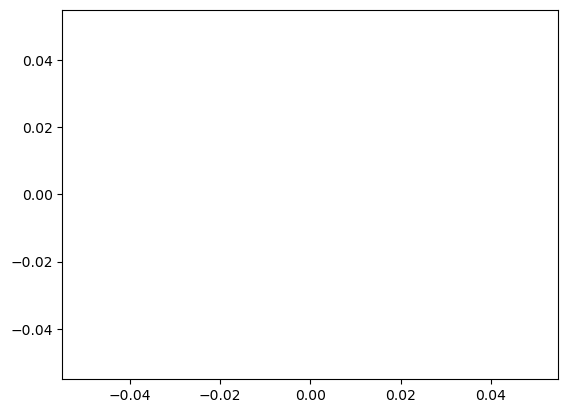

70


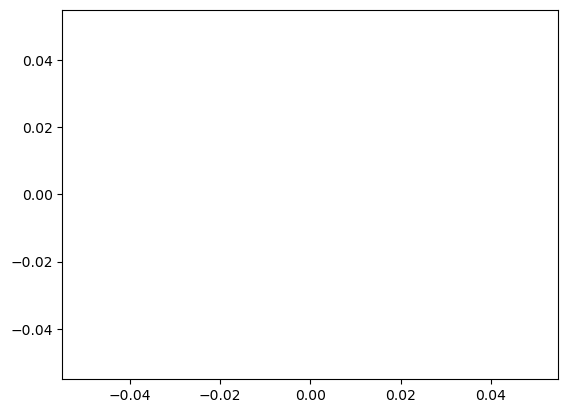

80


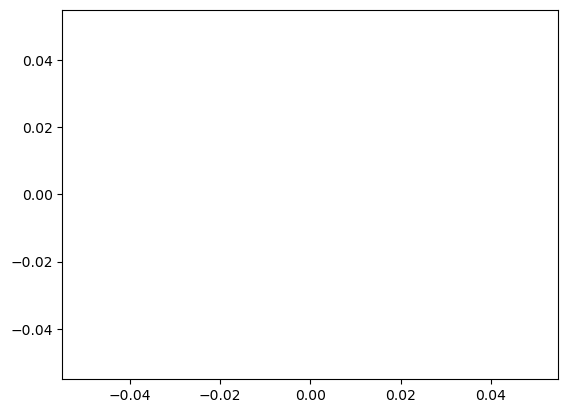

90


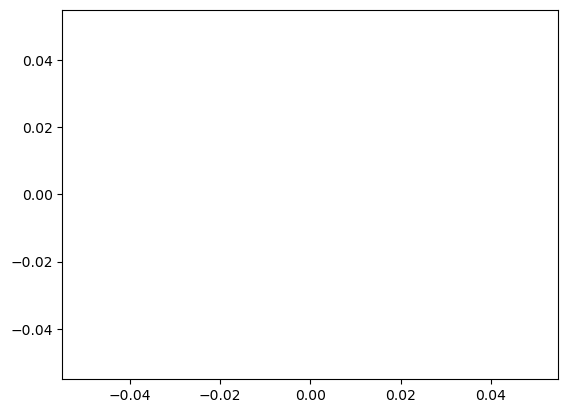

100


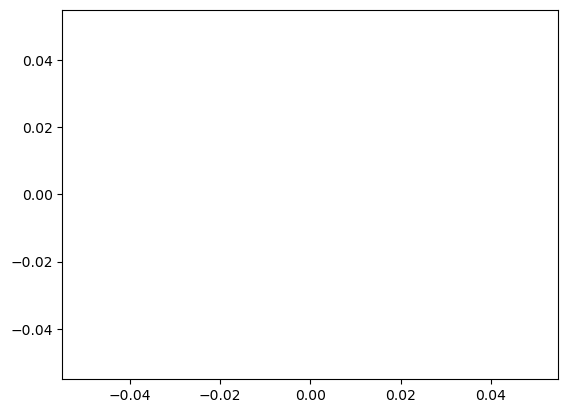

110


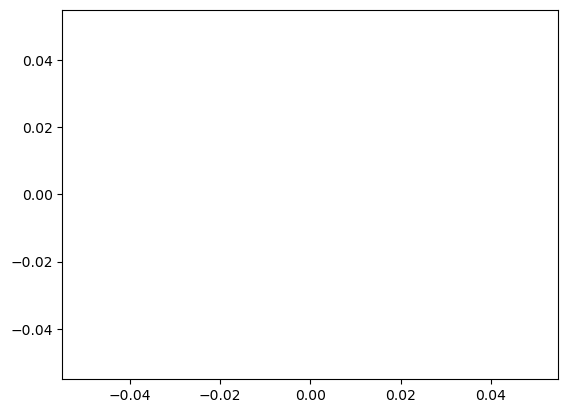

120


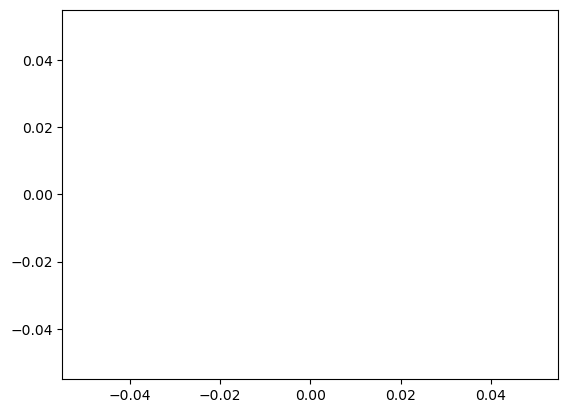

130


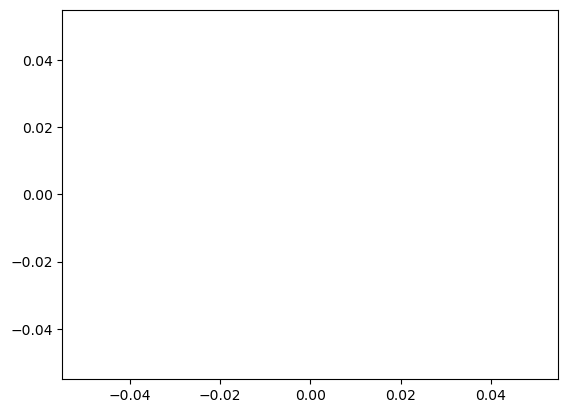

140


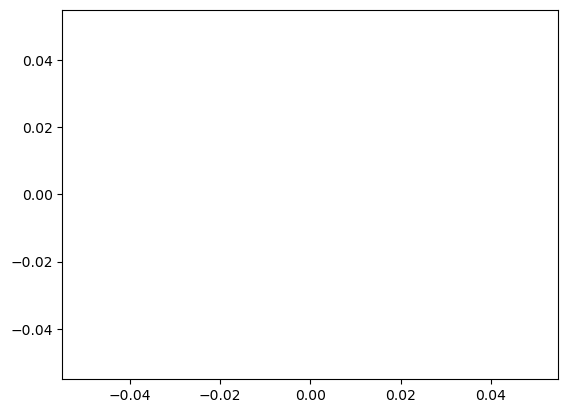

150


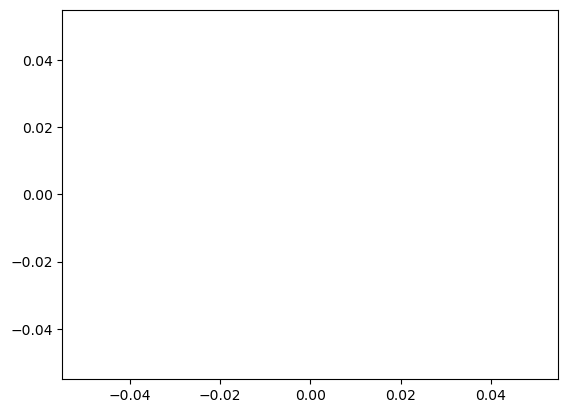

160


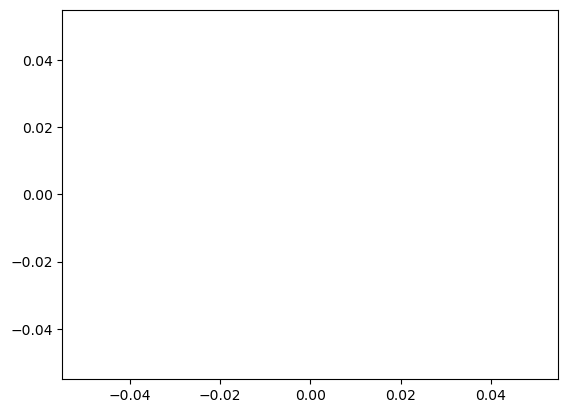

170


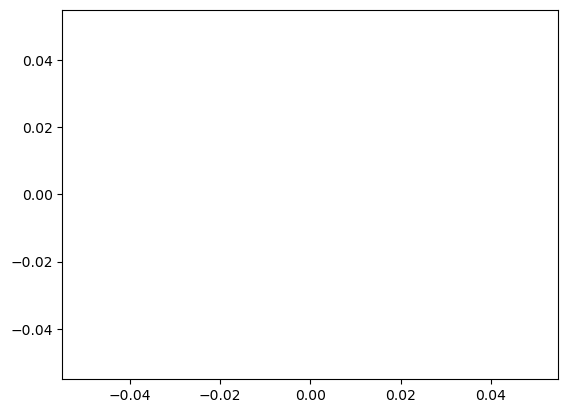

180


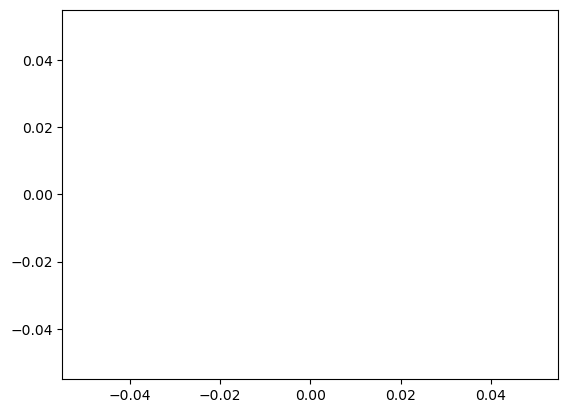

190


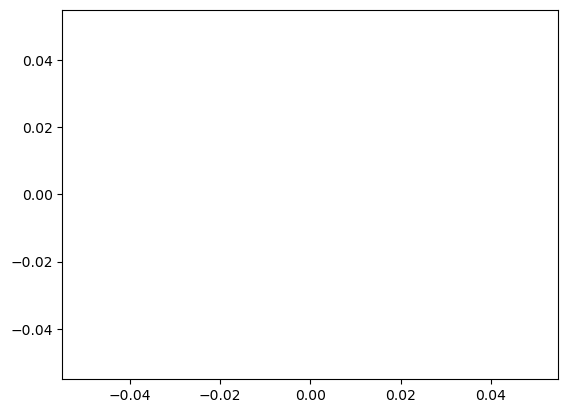

200


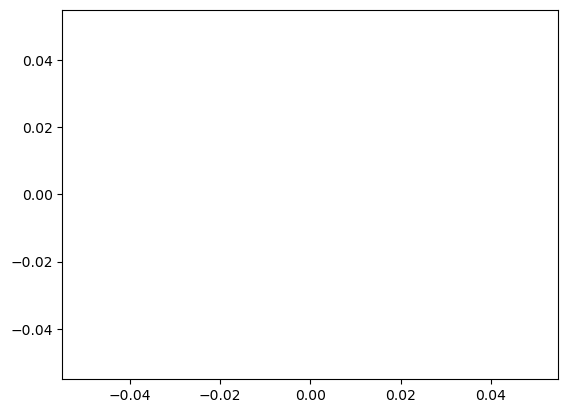

210


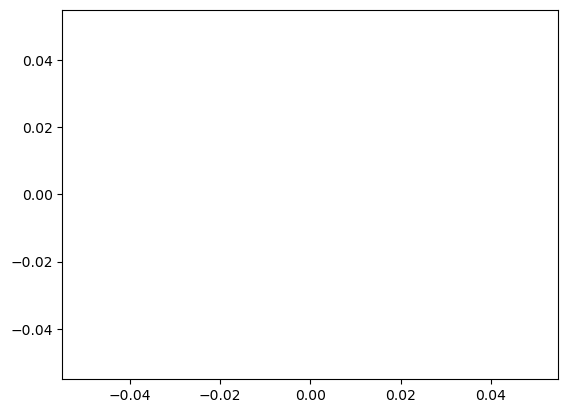

220


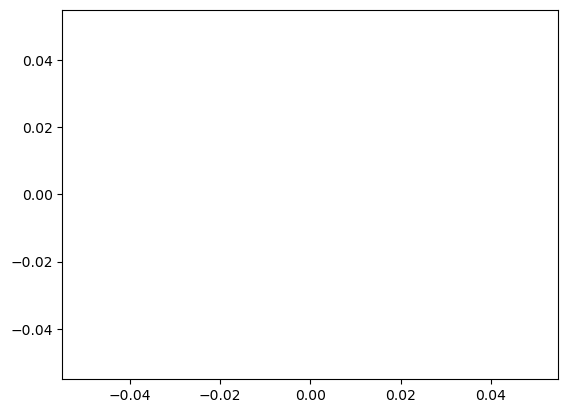

230


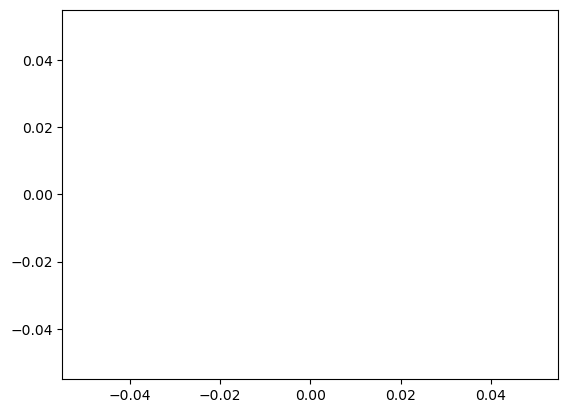

240


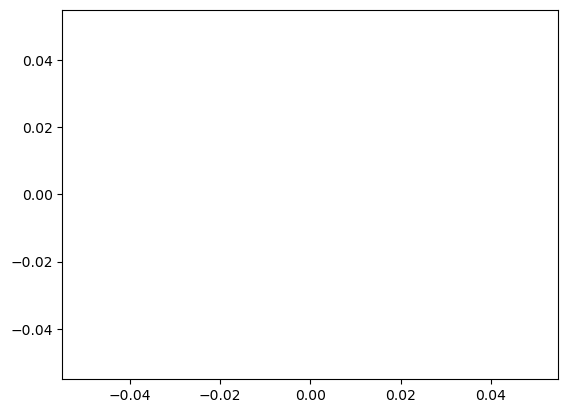

250


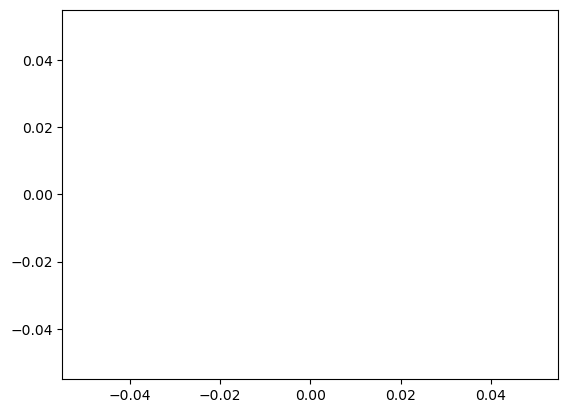

260


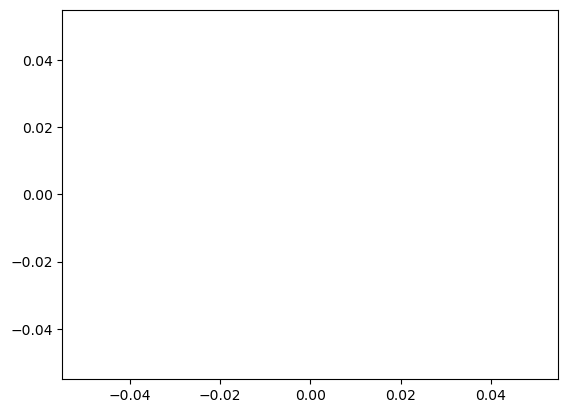

270


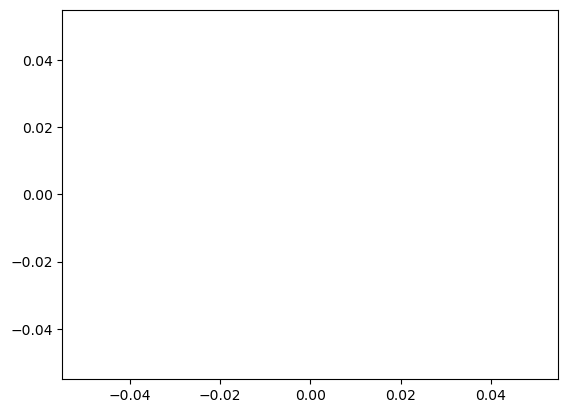

280


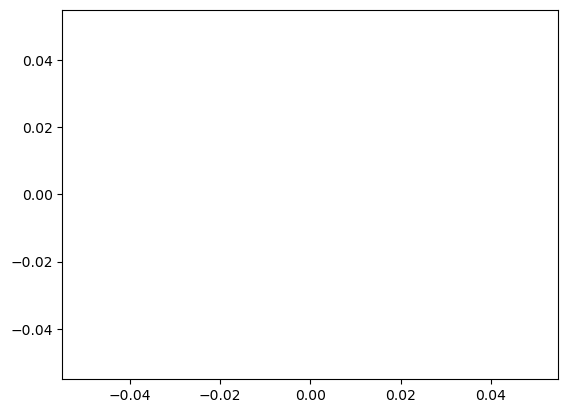

290


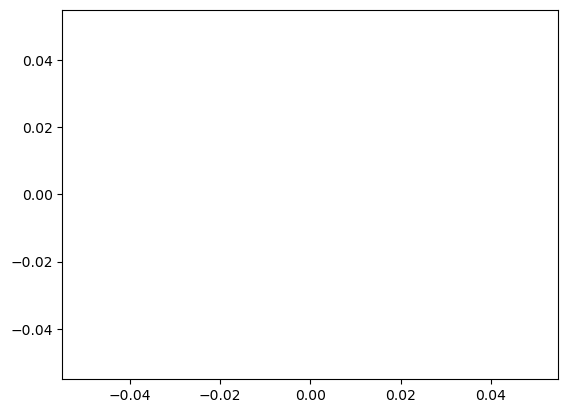

In [65]:

n=100
x=np.linspace(-5,5,n)
y=np.exp(-0.5*x**2)
dt=0.01
nu=1.0
plt.plot(x, y)
plt.show()
for i in range(300):
    y+=burgers(y,0.0*np.exp(-0.5*x**2),dt,10/n,nu)*dt
    if i%10==0:
        print(i)
        plt.plot(x, y)
        plt.show()